In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
base_dir = 'times'
figures_dir = 'figures'
#hosts = ['macbook']
#hosts_labels = ['MacBook Pro']
#sizes = ['small', 'medium']
#benchmarks = []
hosts = ['macbook', 'iw5', 'threadripper00', 'threadripper02','Carl9800']
hosts_labels = ['MacBook Pro', 'Intel W5-2445', 'AMD Threadripper 1950X', 'AMD Threadripper 7975WX', 'AMD Ryzen 7 9800x3D']
sizes = ['small', 'medium', 'large']
benchmarks = ['full', 'partial', 'no', 'metadata']
benchmarks_labels = ['Full restore', 'Partial restore', 'No restore', 'Metadata only']
#legacies = ['ancient', 'true', 'false']
legacies = ['true', 'false']
sparsity_size = 'medium'
filesize_size = 'small'

# Load the regular runs
runs = dict()
for host in hosts:
    runs[host] = dict()
    for size in sizes:
        runs[host][size] = dict()
        for benchmark in benchmarks:
            runs[host][size][benchmark] = dict()
            for legacy in legacies:
                with open(f'{base_dir}/{host}_{size}_{benchmark}_{legacy}.csv', 'r') as f:
                    lines = np.array([float(line.strip()) for line in f.readlines()])
                    runs[host][size][benchmark][legacy] = lines / 1000

hosts += ['avg']
hosts_labels += ['Average']
runs['avg'] = dict()
for size in sizes:
    runs['avg'][size] = dict()
    for benchmark in benchmarks:
        runs['avg'][size][benchmark] = dict()
        for legacy in legacies:
            runs['avg'][size][benchmark][legacy] = np.mean([runs[host][size][benchmark][legacy] for host in hosts[:-1]], axis=0)

# Load the sparsity runs
#for host in hosts:
#    runs[host][sparsity_size] = dict()
#    runs[host][sparsity_size]['sparse'] = dict()
#    for legacy in legacies:
#        runs[host][sparsity_size]['sparse'][legacy] = dict()
#        with open(f'{base_dir}/{host}_{sparsity_size}_sparse_{legacy}.csv', 'r') as f:
#            lines = np.array([[float(elem) for elem in line.strip().split(';')] for line in f.readlines()])
#            runs[host][sparsity_size]['sparse'][legacy] = lines

# Load the filesizes runs
#for host in hosts:
#    if host not in runs: runs[host] = dict()
#    if filesize_size not in runs[host]: runs[host][filesize_size] = dict()
#    if 'filesize' not in runs[host][filesize_size]: runs[host][filesize_size]['filesize'] = dict()
#    for legacy in legacies:
#        runs[host][filesize_size]['filesize'][legacy] = dict()
#        with open(f'{base_dir}/{host}_{filesize_size}_size_{legacy}.csv', 'r') as f:
#            lines = np.array([[float(elem) for elem in line.strip().split(';')] for line in f.readlines()])
#            runs[host][filesize_size]['filesize'][legacy] = lines

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

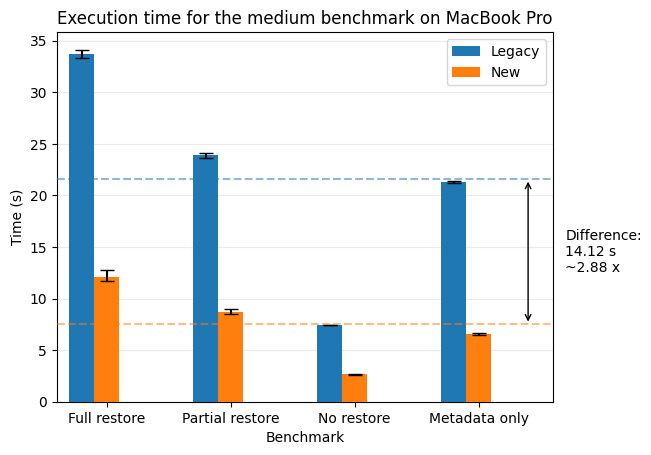

In [5]:
def clean(times):
    if len(times) == 1:
        return times[0], times[0], times[0]
    no_outliers = np.sort(times)[1:-1]
    return np.mean(no_outliers), np.min(no_outliers), np.max(no_outliers)

def plot_bars_regular(runs, host, size, host_label):
    width = .2
    off = -1.5*width
    super_means = []
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for l in legacies:
        means = []
        mins = []
        maxs = []
        for b in benchmarks:
            mean, mi, ma = clean(runs[host][size][b][l])
            means.append(mean)
            mins.append(mi)
            maxs.append(ma)

        super_means.append(np.mean(means))
        means = np.array(means)
        mins = np.array(mins)
        maxs = np.array(maxs)

        if l == 'true':
            label = 'Legacy'
        elif l == 'false':
            label = 'New'
        else:
            label = 'Ancient'
        plt.bar(np.arange(len(benchmarks)) + off, means, yerr=[means-mins, maxs-means], capsize=5, width=.2, label=label, zorder=3)
        off += width
    plt.legend()

    plt.hlines(super_means[0], -.5, len(benchmarks)-.5, colors=colors[0], alpha=.5, linestyles='dashed', label='Legacy mean', zorder=4)
    plt.hlines(super_means[1], -.5, len(benchmarks)-.5, colors=colors[1], alpha=.5, linestyles='dashed', label='New mean', zorder=4)
    #plt.hlines(super_means[2], -.5, len(benchmarks)-.5, colors=colors[2], alpha=.5, linestyles='dashed', label='New mean', zorder=4)

    # Highlight the difference between the two means
    plt.annotate('', xy=(3.3, super_means[1]), xytext=(3.3, super_means[0]), arrowprops=dict(arrowstyle='<->', color='black'))
    plt.text(3.6, (super_means[0]+super_means[1])/2, f'Difference:\n{np.abs(super_means[1]-super_means[0]):.2f} s\n~{super_means[0]/super_means[1]:.2f} x', verticalalignment='center', horizontalalignment='left')

    #plt.annotate('', xy=(3.3, super_means[2]), xytext=(3.3, super_means[1]), arrowprops=dict(arrowstyle='<->', color='black'))
    #plt.text(3.6, (super_means[1]+super_means[2])/2, f'Difference:\n{np.abs(super_means[2]-super_means[1]):.2f} ms\n~{super_means[1]/super_means[2]:.2f} x', verticalalignment='center', horizontalalignment='left')

    #plt.text(3.6, super_means[2]/2, f'Total:\n{np.abs(super_means[2]-super_means[0]):.2f} ms\n~{super_means[0]/super_means[2]:.2f} x', verticalalignment='center', horizontalalignment='left')

    plt.xticks(np.arange(len(benchmarks))-.5*width, benchmarks_labels)
    plt.xlim(-.5, len(benchmarks)-.5)
    plt.ylabel('Time (s)')
    plt.xlabel('Benchmark')
    plt.title(f'Execution time for the {size} benchmark on {host_label}')
    plt.grid(axis='y', alpha=.25, zorder=0)

plot_bars_regular(runs, hosts[0], 'medium', hosts_labels[0])
plt.show()

In [21]:
if not os.path.exists(figures_dir):
    os.mkdir(figures_dir)

for host, host_label in zip(hosts, hosts_labels):
    for size in sizes:
        plot_bars_regular(runs, host, size, host_label)
        # More horizontal space for the legend
        plt.tight_layout(rect=[0, 0, 1, .9])
        plt.savefig(f'{figures_dir}/{host}_{size}.png', dpi=300)
        plt.clf()

<Figure size 640x480 with 0 Axes>

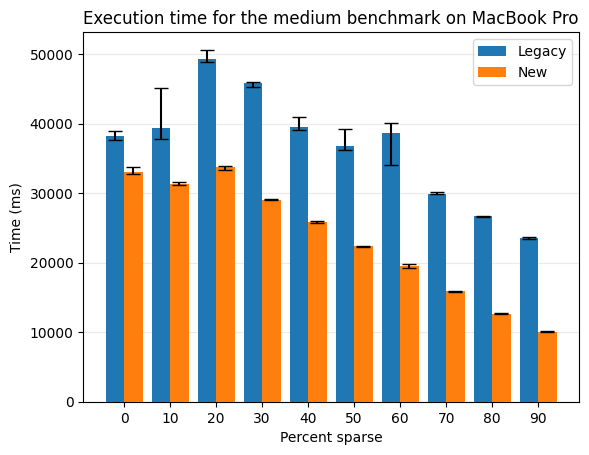

In [ ]:
def plot_bars_sparse(runs, host, host_label):
    width = 4
    off = -(.5*width)

    for l in legacies:
        measured = runs[host][sparsity_size]['sparse'][l]
        measured = np.sort(measured, axis=1)
        measured = measured[:, 1:-1]
        means = np.mean(measured, axis=1)
        mins = np.min(measured, axis=1)
        maxs = np.max(measured, axis=1)

        plt.bar((np.arange(10) * 10) + off, means, yerr=[means-mins, maxs-means], capsize=5, width=width, label='Legacy' if l == 'true' else 'New', zorder=3)
        off += width
    plt.legend()


    plt.xticks(np.arange(10) * 10)
    #plt.xlim(-.5, len(benchmarks)-.5)
    plt.ylabel('Time (ms)')
    plt.xlabel('Percent sparse')
    plt.title(f'Execution time for the {sparsity_size} benchmark on {host_label}')
    plt.grid(axis='y', alpha=.25, zorder=0)

plot_bars_sparse(runs, hosts[0], hosts_labels[0])
plt.show()

[115.34404542 122.25245518 129.42973761 123.84795982 115.35505837
 127.46808873 124.04027211 108.69692169 131.46291228 157.07112336
 130.61298657 100.17300928 123.1085285  130.24649421 104.00381983
  78.42572594 128.10504868 117.34433962 133.68762788 114.57658041
  88.52080377]
[113.4807648  117.21492744 128.15935335 123.03259329 111.37356187
 122.9954018  110.81485803 107.60393604 130.41424093 155.43234588
 125.25375735  98.66916355 121.15295749 128.79191548 101.26704686
  76.19237943 121.84323859 115.33147891 131.95605343 113.22355769
  85.39597657]
[116.54128223 123.98391813 130.47966142 125.1609803  118.02438418
 131.05926272 131.35315814 110.01257545 133.1572931  158.31600408
 132.77303163 101.45571245 124.54869359 131.01869159 106.19084763
  79.71842766 130.49815498 119.00023918 135.72789719 116.04089677
  90.75778078]
(21,) (21,) (21,)
[202.55756579 214.09772261 224.53166093 219.26549511 205.16435986
 224.81164641 226.68854742 196.33507266 222.82243795 271.32774284
 221.24368778

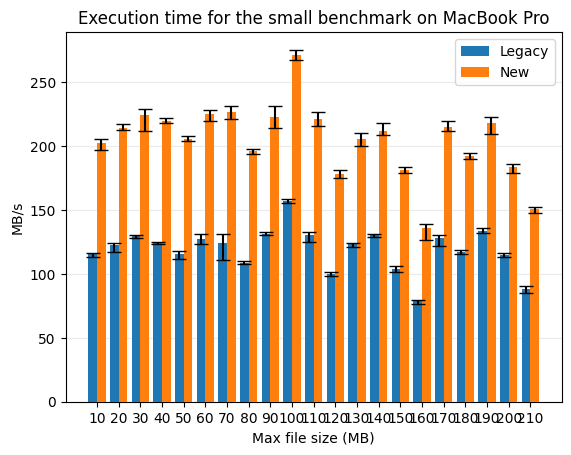

In [ ]:
def plot_bars_sparse(runs, host, host_label):
    width = 4
    off = -(.5*width)
    mb = np.array([492.62, 508.83, 554.93, 520.92, 474.34, 561.72, 569.81, 437.41, 582.43, 776.54, 575.04, 395.17, 524.35, 560.76, 408.41, 285.95, 565.84, 497.54, 612.54, 471.01, 335.35])

    for l in legacies:
        measured = runs[host][filesize_size]['filesize'][l]
        measured = np.sort(measured, axis=1)
        measured = measured[:, 1:-1]
        means = np.mean(measured, axis=1)
        means = mb / means * 1000
        maxs = mb / np.min(measured, axis=1) * 1000
        mins = mb / np.max(measured, axis=1) * 1000
        print (means)
        print (mins)
        print (maxs)
        print (means.shape, mins.shape, maxs.shape)

        plt.bar(((np.arange(1, means.shape[0]+1)) * 10) + off, means, yerr=[means-mins, maxs-means], capsize=5, width=width, label='Legacy' if l == 'true' else 'New', zorder=3)
        off += width
    plt.legend()


    plt.xticks(np.arange(1, means.shape[0]+1) * 10)
    plt.ylabel('MB/s')
    plt.xlabel('Max file size (MB)')
    plt.title(f'Execution time for the {filesize_size} benchmark on {host_label}')
    plt.grid(axis='y', alpha=.25, zorder=0)

plot_bars_sparse(runs, hosts[0], hosts_labels[0])
plt.show()

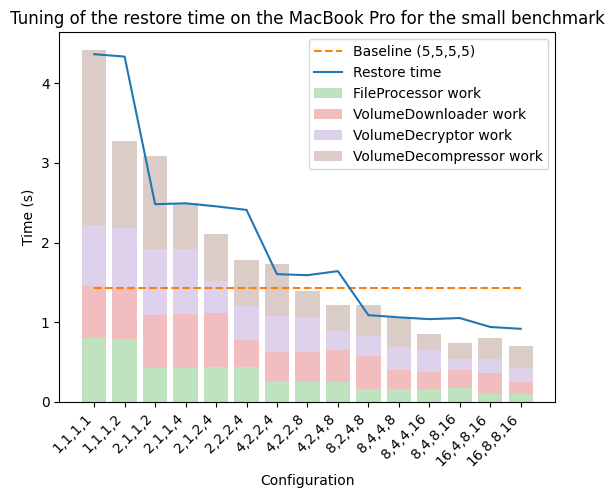

In [53]:
# Tuning plot

def plot_tuning(host_idx, size):
    tuning = dict()
    with open(f'times/{hosts[host_idx]}_{size}_tuning.csv', 'r') as f:
        keys = f.readline().strip().split(';')
        for line in f.readlines():
            line = line.strip().split(';')
            for key, value in zip(keys, line):
                if key not in tuning: tuning[key] = []
                tuning[key].append(float(value))
    
    for key in keys[4:]:
        tuning[key] = np.array(tuning[key]) / 1000

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    xticks = [','.join(map(str, map(int, z))) for z in zip(tuning[keys[0]], tuning[keys[1]], tuning[keys[2]], tuning[keys[3]])]
    plt.bar(np.arange(len(tuning[keys[0]])-1), tuning['work_FileProcessor'][:-1], label='FileProcessor work', alpha=.3, color=colors[2])
    prev = tuning['work_FileProcessor'][:-1]
    plt.bar(np.arange(len(tuning[keys[0]])-1), tuning['work_VolumeDownloader'][:-1], bottom=prev, label='VolumeDownloader work', alpha=.3, color=colors[3])
    prev = prev + tuning['work_VolumeDownloader'][:-1]
    plt.bar(np.arange(len(tuning[keys[0]])-1), tuning['work_VolumeDecryptor'][:-1], bottom=prev, label='VolumeDecryptor work', alpha=.3, color=colors[4])
    prev = prev + tuning['work_VolumeDecryptor'][:-1]
    plt.bar(np.arange(len(tuning[keys[0]])-1), tuning['work_VolumeDecompressor'][:-1], bottom=prev, label='VolumeDecompressor work', alpha=.3, color=colors[5])
    plt.hlines(tuning['wall_clock_restore'][-1], 0, len(tuning['wall_clock_restore'])-2, colors='r', linestyles='dashed', label=f'Baseline ({xticks[-1]})', color=colors[1])
    plt.plot(tuning['wall_clock_restore'][:-1], label='Restore time', color=colors[0])
    plt.xticks(np.arange(len(tuning[keys[0]])-1), xticks[:-1], rotation=45, ha='right')
    plt.ylabel('Time (s)')
    plt.xlabel('Configuration')
    plt.legend()
    plt.title(f'Tuning of the restore time on the {hosts_labels[host_idx]} for the {size} benchmark')
    plt.show()

plot_tuning(0, 'small')